# MONAIを利用した脾臓の3Dセグメンテーション学習(3D UNet利用)

本チュートリアルにおいて、高い精度を得るには数時間以上をかけて学習を行いますので、時間に余裕がある時に試してください。

本チュートリアルは [Project-MONAI](https://github.com/Project-MONAI) の脾臓のセグメンテーションチュートリアルを簡略化し、一部修正したものです。

前回までと違い、このチュートリアルでは、3D UNetを利用した学習を行います。スライスベースの学習では学習時にランダムに2Dスライスをサンプリングして学習を行いましたが、3D UNetに対して学習を行う場合、ランダムに3D部分画像を習得して学習を行います。

## 必要なライブラリのインストールを行います

In [1]:
!pip install -U SimpleITK "monai[ignote, nibabel, torchvision, tdqm]==1.1.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.9 MB/s eta 0:00:00


# 必要なライブラリのインポート

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## データディレクトリの設定

In [2]:
#directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = "output_root/"
os.makedirs(root_dir, exist_ok=True)
print(root_dir)

output_root/


## データのダウンロード
MICCAIのMedical Segmentation Decathlon ( [http://medicaldecathlon.com/](http://medicaldecathlon.com/) ) で提供されたSpleenデータを利用します。

In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [03:42, 7.23MB/s]                            

2023-09-05 12:57:57,700 - INFO - Downloaded: output_root/Task09_Spleen.tar


2023-09-05 12:58:00,694 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-09-05 12:58:00,695 - INFO - Writing into directory: output_root/.


## データセットの読み込み用パスを構成する
imagesTrフォルダ以下のniiファイルが画像で、labelsTr以下のniiファイルが脾臓のラベルになります。

※MICCAIでは現在もこの構成でチャレンジデータを配布しています。

In [4]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

# 後ろから9個のデータを検証データとし、それ以外を学習データとします
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Transformの準備

In [17]:

# サンプリングされる部分画像の１辺あたりのピクセル数
# サンプルデータの解像度を超えないサイズ(4の倍数推奨)に設定してください
# GPUメモリが足りない場合はこのサイズを小さくしましょう
roi_size = 96

# 着目するCT値の範囲
# 学習対象臓器に応じて設定することでサンプル不足による学習精度の低下をある程度抑制できる
img_val_min, img_val_max = -57, 164

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=img_val_min,
            a_max=img_val_max,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(roi_size, roi_size, roi_size),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(roi_size, roi_size, roi_size),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=img_val_min,
            a_max=img_val_max,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Transformの出力を確認

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


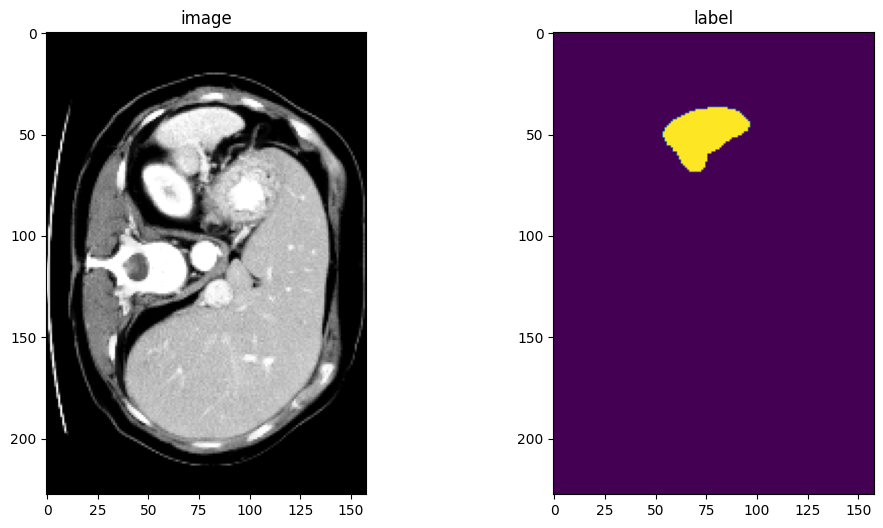

In [6]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## データローダーを定義

In [7]:
## DataLoader(学習や検証時にモデルにサンプルを供給するクラス)の設定
# キャッシュメモリに応じて0以上～1.0までを設定
# データ数が多い場合、1.0にするとかなりシステムメモリを圧迫するので、適宜調整
cache_rate = 1.0

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=cache_rate, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=cache_rate, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


## モデル、損失関数、オプティマイザーの定義

In [8]:
device = torch.device("cuda:0")

## 3D UNetとして定義
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## 学習の実施

学習ループは前回までのチュートリアルとほぼ同じです
ただし、学習時間は2Dモデルと比べると長くなります。

In [9]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages

1/16, train_loss: 0.6483
2/16, train_loss: 0.6527
3/16, train_loss: 0.6379
4/16, train_loss: 0.6656
5/16, train_loss: 0.6577
6/16, train_loss: 0.6424
7/16, train_loss: 0.6462
8/16, train_loss: 0.6560
9/16, train_loss: 0.6299
10/16, train_loss: 0.6435
11/16, train_loss: 0.6385
12/16, train_loss: 0.6525
13/16, train_loss: 0.6460
14/16, train_loss: 0.6182
15/16, train_loss: 0.6297
16/16, train_loss: 0.6313
epoch 1 average loss: 0.6435
----------
epoch 2/50
1/16, train_loss: 0.6500
2/16, train_loss: 0.6286
3/16, train_loss: 0.6281
4/16, train_loss: 0.6388
5/16, train_loss: 0.6309
6/16, train_loss: 0.6195
7/16, train_loss: 0.6420
8/16, train_loss: 0.6306
9/16, train_loss: 0.6134
10/16, train_loss: 0.5760
11/16, train_loss: 0.6449
12/16, train_loss: 0.6183
13/16, train_loss: 0.6317
14/16, train_loss: 0.6446
15/16, train_loss: 0.6350
16/16, train_loss: 0.6096
epoch 2 average loss: 0.6276
saved new best metric model
current epoch: 2 current mean dice: 0.0335
best mean dice: 0.0335 at epoch: 2


In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

## Lossおよび精度の曲線をプロットしてみる

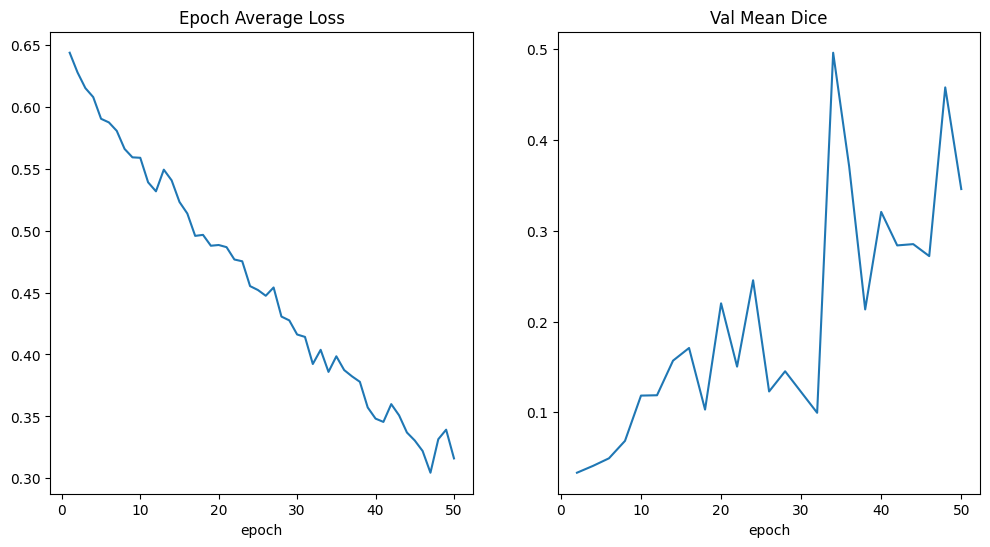

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## 最高スコアが得られたモデルで推論してみる

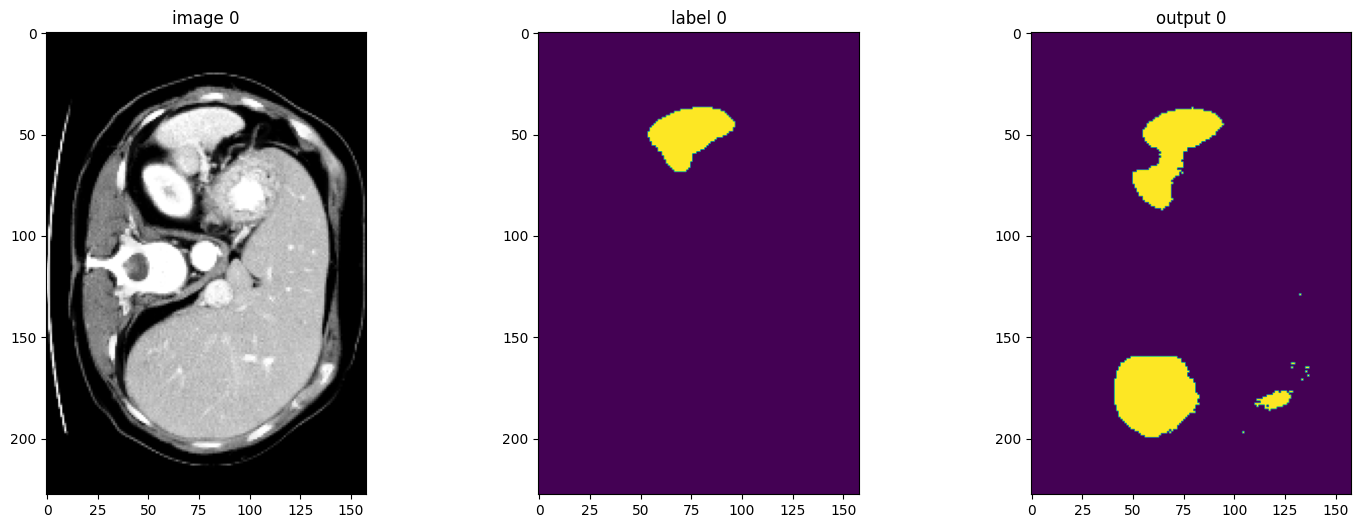

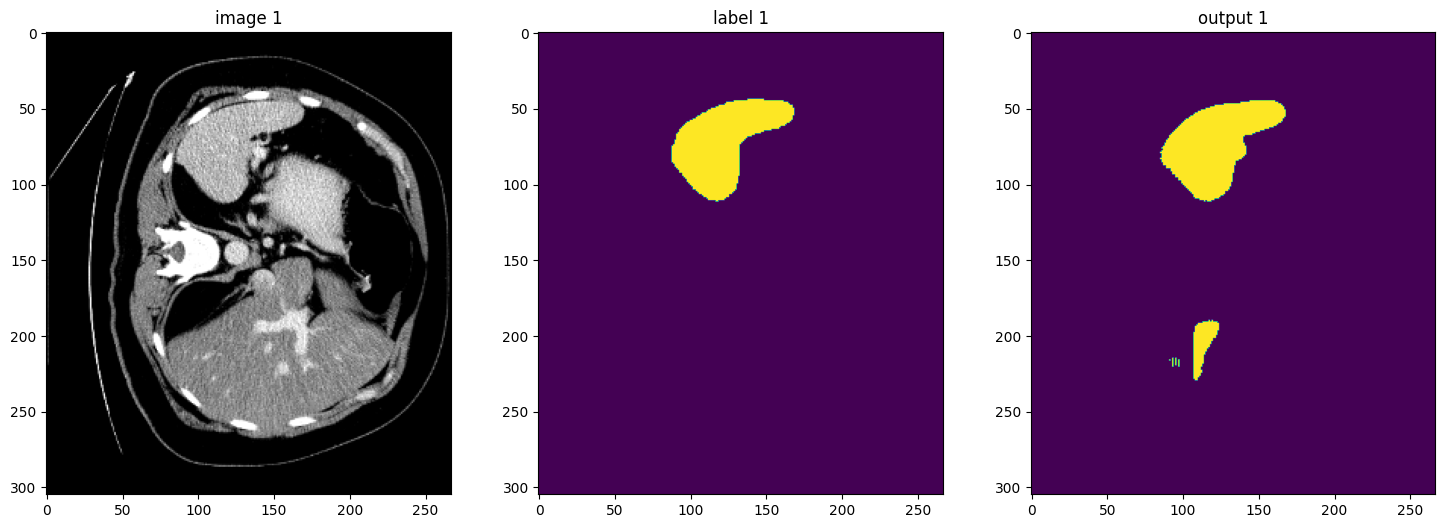

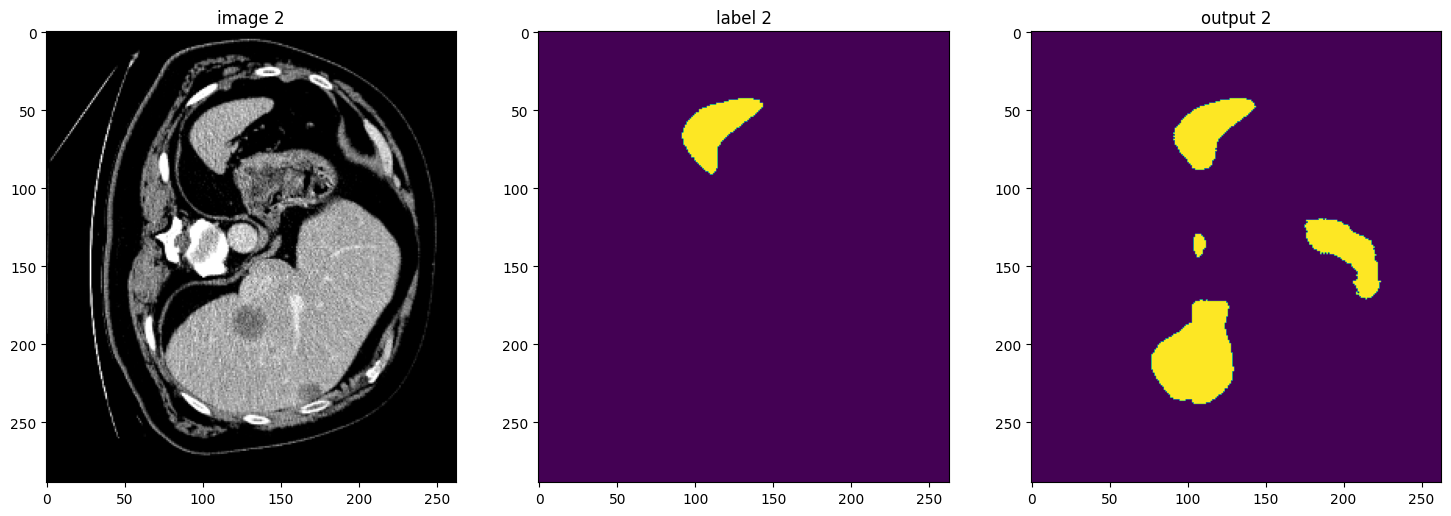

In [11]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## 元データのSpacingで推論精度を評価する

In [18]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=img_val_min,
            a_max=img_val_max,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        win_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, win_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.5097414255142212


## テストセットに対して推論してみる

Spleenデータには正解ラベルのないデータとしてimagesTsフォルダ以下で提供されている。これらのデータに対して学習済みモデルで推論してみましょう

In [20]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=img_val_min,
            a_max=img_val_max,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [21]:
from monai.transforms import LoadImage
loader = LoadImage()

2023-09-05 13:20:00,014 INFO image_writer.py:194 - writing: out/spleen_1/spleen_1_seg.nii.gz


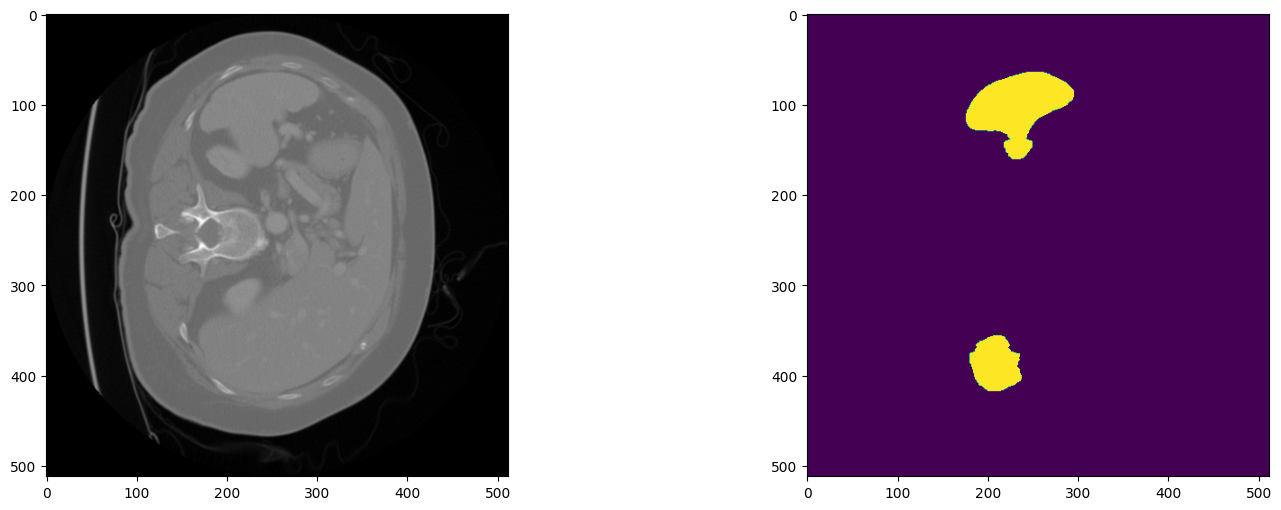

2023-09-05 13:20:03,189 INFO image_writer.py:194 - writing: out/spleen_11/spleen_11_seg.nii.gz


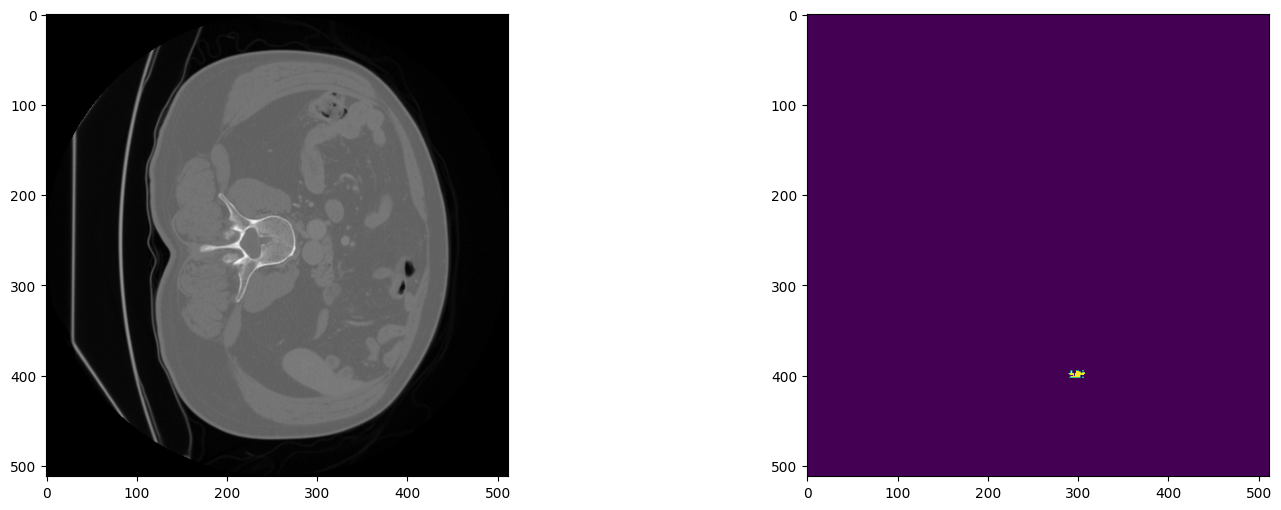

2023-09-05 13:20:09,828 INFO image_writer.py:194 - writing: out/spleen_15/spleen_15_seg.nii.gz


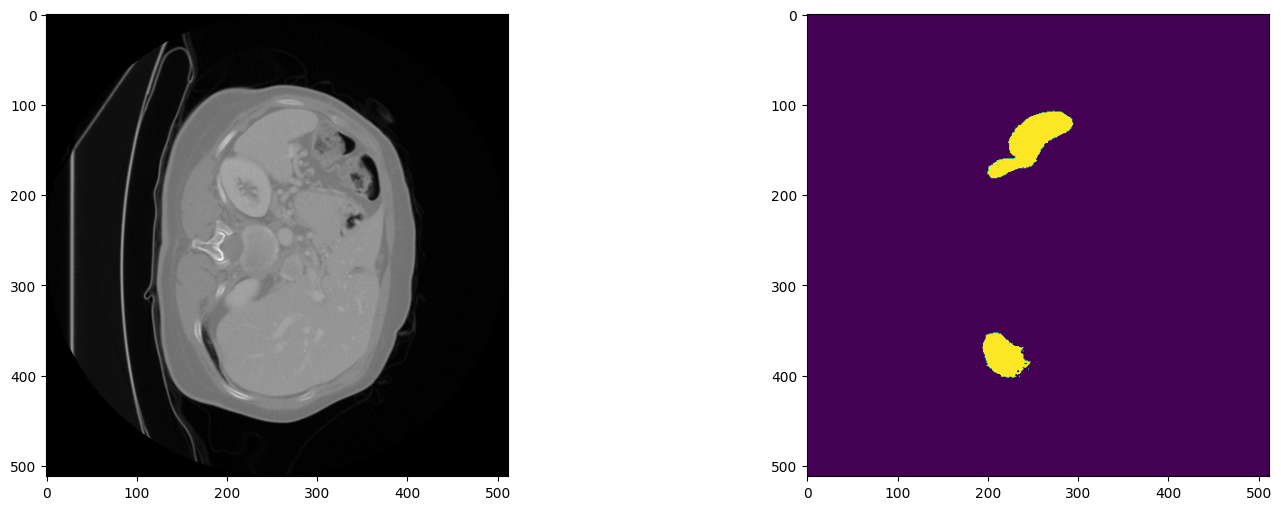

2023-09-05 13:20:11,880 INFO image_writer.py:194 - writing: out/spleen_23/spleen_23_seg.nii.gz


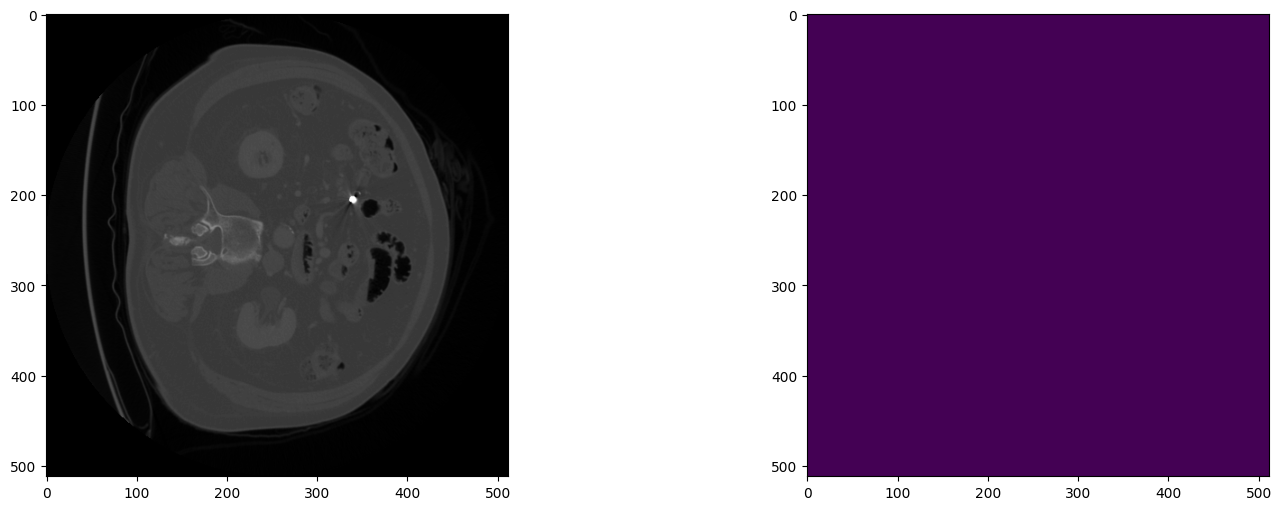

2023-09-05 13:20:16,359 INFO image_writer.py:194 - writing: out/spleen_30/spleen_30_seg.nii.gz


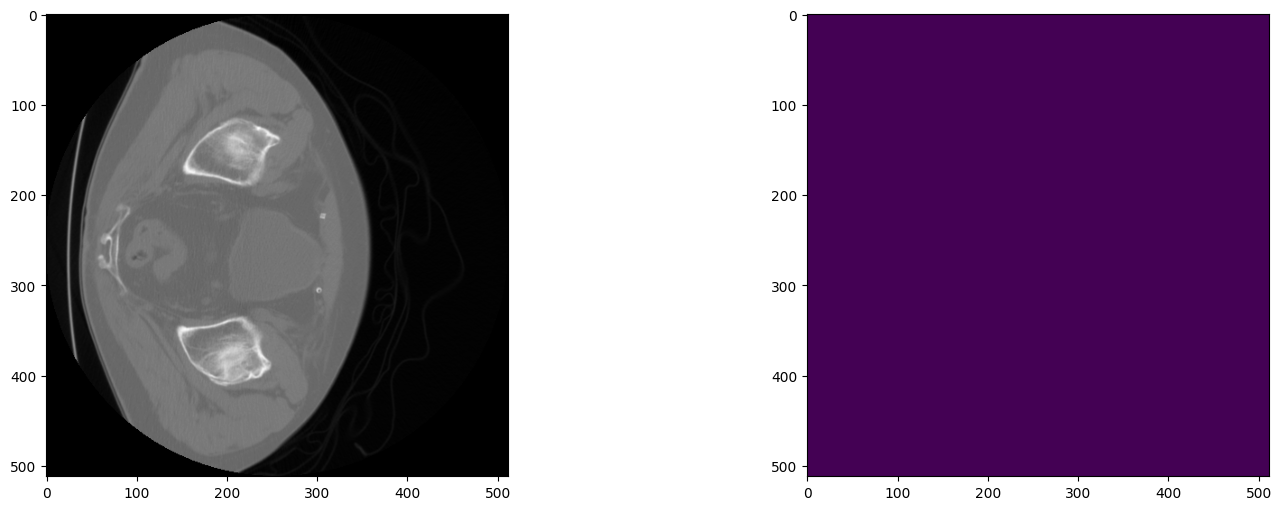

2023-09-05 13:20:20,482 INFO image_writer.py:194 - writing: out/spleen_34/spleen_34_seg.nii.gz


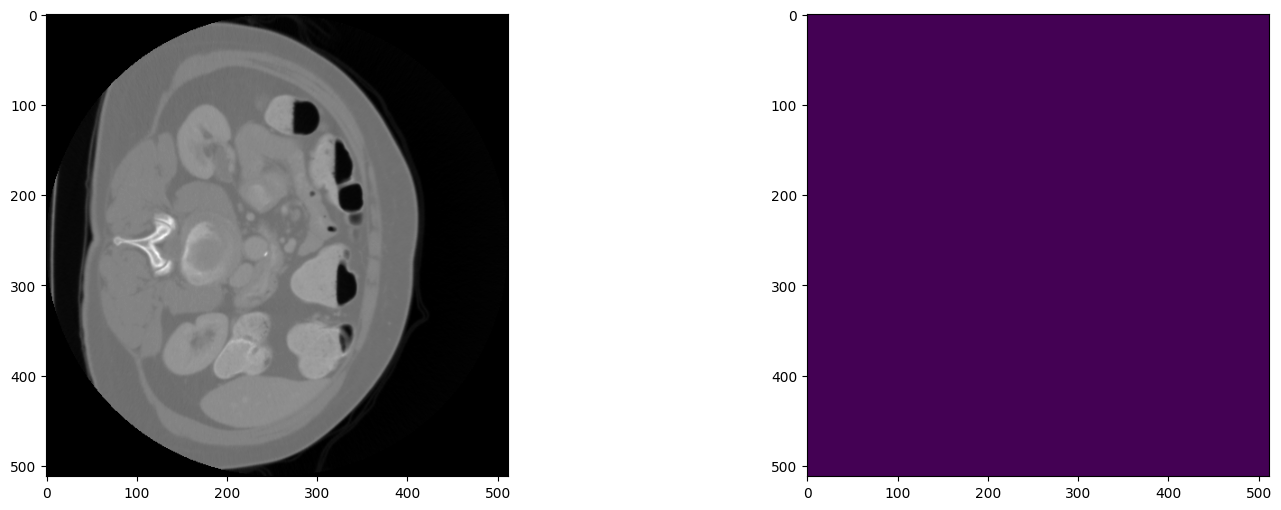

2023-09-05 13:20:22,889 INFO image_writer.py:194 - writing: out/spleen_35/spleen_35_seg.nii.gz


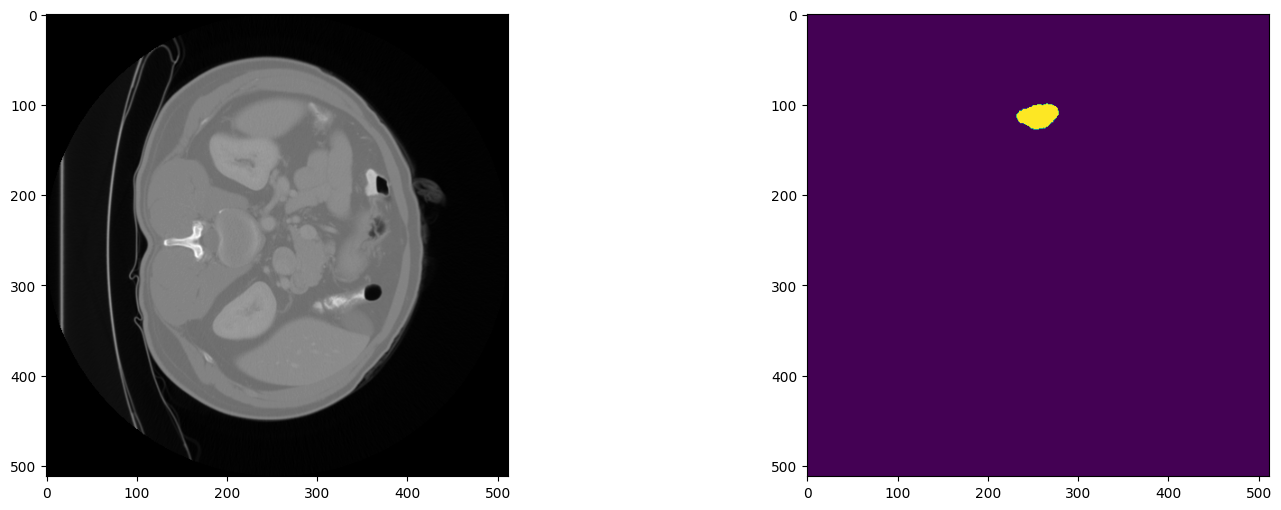

2023-09-05 13:20:26,131 INFO image_writer.py:194 - writing: out/spleen_36/spleen_36_seg.nii.gz


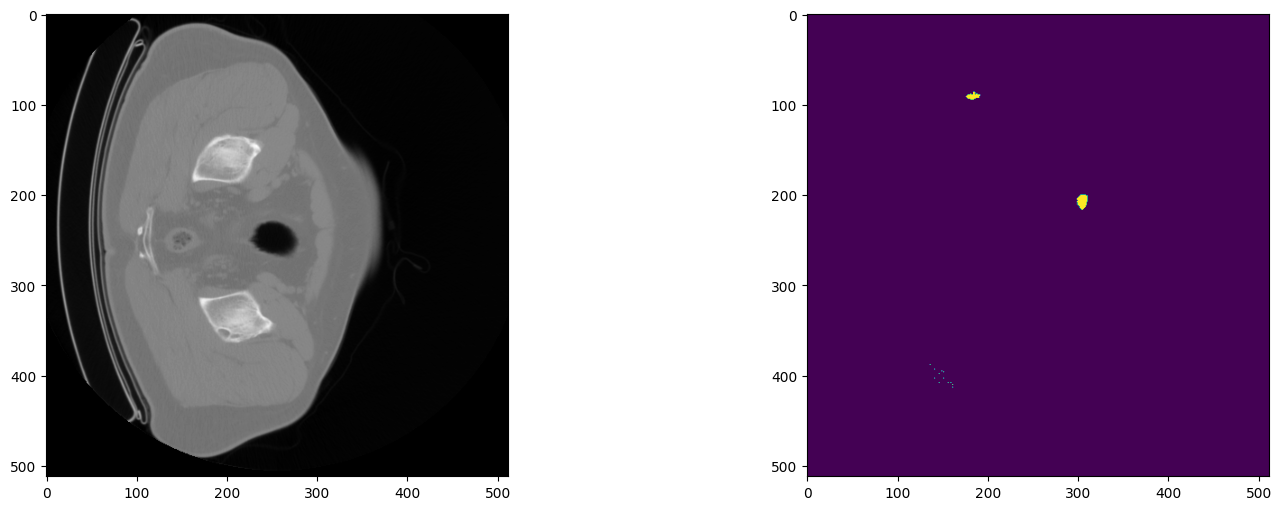

2023-09-05 13:20:31,113 INFO image_writer.py:194 - writing: out/spleen_37/spleen_37_seg.nii.gz


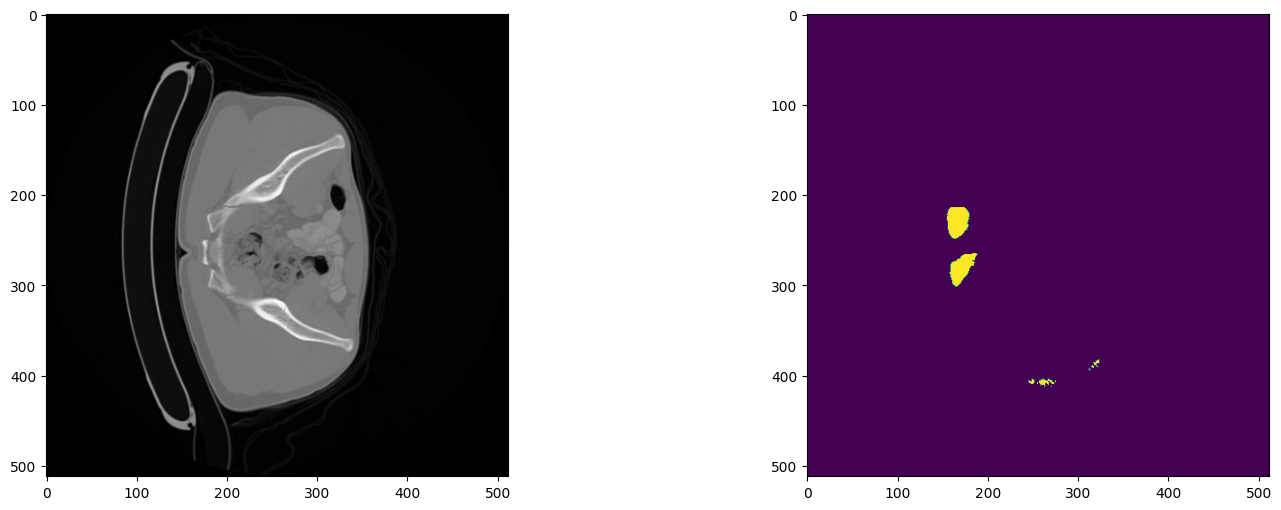

2023-09-05 13:20:36,634 INFO image_writer.py:194 - writing: out/spleen_39/spleen_39_seg.nii.gz


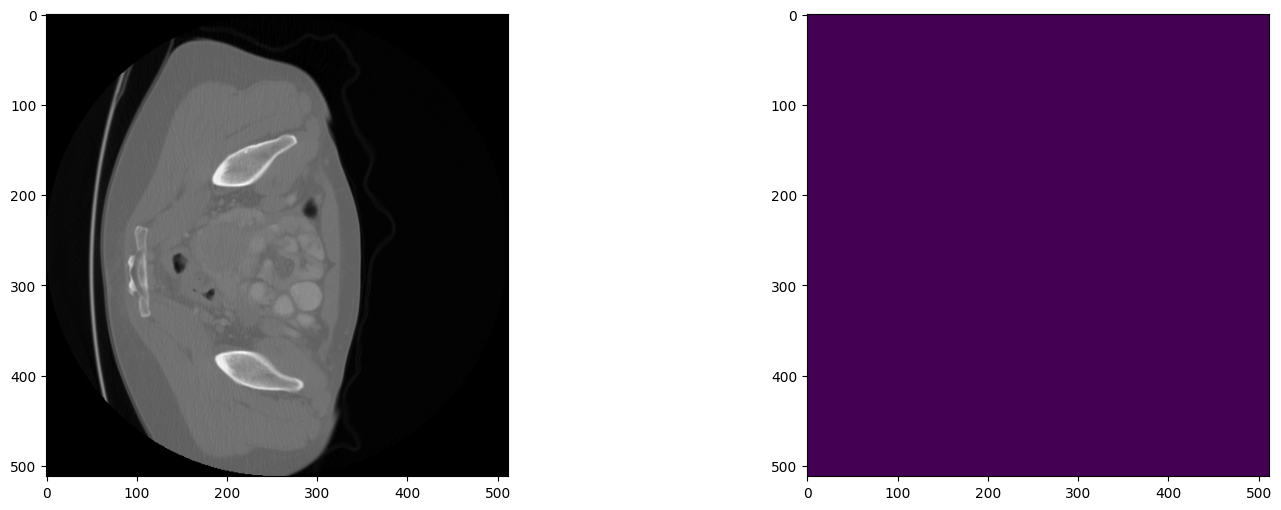

2023-09-05 13:20:40,526 INFO image_writer.py:194 - writing: out/spleen_42/spleen_42_seg.nii.gz


KeyboardInterrupt: ignored

In [29]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        win_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, win_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        ## 推論結果の表示
        if True:
          test_output = from_engine(["pred"])(test_data)
          original_image = loader(test_output[0].meta["filename_or_obj"])

          plt.figure("check", (18, 6))
          plt.subplot(1, 2, 1)
          plt.imshow(original_image[0][:, :, 20], cmap="gray")
          plt.subplot(1, 2, 2)
          plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
          plt.show()